<h1><center>Find Out Poison Substances (Updated)</center></h1>

### Introduction
This project is to find out the poison substances labeled by ICD-9 codes of suicide attempts from NOTEEVENTS table. The ICD-9 code is E950.0 - E950.9 (Suicide and self-inflicted poisoning by solid or liquid substances).

__Update:__
The fentanyl discovery is appended in the end.

__The project follows these steps:__
1. Extract the poison suicide records from NOTEEVENTS table. To do so, the SUJECT_IDs that are with ICD-9 codes of E950.0-E950.9 are firstly extracted from table DIAGNOSES_ICD.
2. Extract the poison substances by the keyword "overdose". The words that comes around "overdose" are extracted, and then are processed to get the meaningful names of substances, such as medicine name like "Tylenol".
__Note: by this method, the substances that are not round "overdose" are not captured, such as "fentanyl".__
3. HADM_ID is the unique patient hospital stay ID. In the NOTEEVENTS table, HADM_ID has duplicates because one patient hospital stay has multiple doctor's notes presented in the "TEXT" column. The project will remove duplicate substances from the same HADM_ID to get the poison substances of each patient hospital stay.
4. Visualize the frequency of the substances.

In [3]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [4]:
noteevents = pd.read_csv("NOTEEVENTS.csv", sep=",", header=0, index_col="ROW_ID")

/home/cs52205/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/cs52205/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
noteevents = noteevents.reset_index()

In [6]:
pd.set_option("display.max_colwidth", -1)

In [7]:
diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv", header=0, sep=",")

In [8]:
is_poison = diagnoses_icd["ICD9_CODE"].str.contains("E950", na=False)

In [9]:
poison_noteevents = diagnoses_icd[is_poison]

In [10]:
is_poison_subjectID = list(poison_noteevents["SUBJECT_ID"])

__Get the suicide related records from the noteevents table by SUBJECT_ID__

In [11]:
poison_noteevents = noteevents[noteevents["SUBJECT_ID"].isin(is_poison_subjectID)]

In [12]:
poison_noteevents_sorted = poison_noteevents.sort_values(by=['SUBJECT_ID'])

In [13]:
#poison_noteevents_sorted.head()

In [14]:
mydf=poison_noteevents_sorted.copy()

In [15]:
mydf.head()

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE            CHARTTIME  \
1299060  1260818  22          165315.0  2196-04-10  2196-04-10 12:31:00   
14272    12144    22          165315.0  2196-04-10  NaN                   
1299059  1260817  22          165315.0  2196-04-10  2196-04-10 05:40:00   
748432   754333   22          165315.0  2196-04-09  2196-04-09 10:40:00   
748430   754332   22          165315.0  2196-04-09  2196-04-09 10:19:00   

                   STORETIME           CATEGORY           DESCRIPTION  \
1299060  2196-04-10 12:52:00  Nursing/other      Report                 
14272    NaN                  Discharge summary  Report                 
1299059  2196-04-10 05:57:00  Nursing/other      Report                 
748432   NaN                  Radiology          CHEST (PORTABLE AP)    
748430   NaN                  Radiology          CT HEAD W/O CONTRAST   

            CGID  ISERROR  \
1299060  18592.0 NaN        
14272   NaN      NaN        
1299059  14442.0 NaN        
748432  NaN      NaN        
748430  NaN      NaN        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

__mydf is the table that contains all overdose records.__ 

### Extract the poison substances using keyword "overdose".

Words that are extracted:
1. the word before "overdose"
2. the word after "overdose"
3. the last word of "overdose on/of/with something and something"

The unuseful words and wrong spelled words are found after running the functions. They are put up to the beginning for filtering purpose.

In [16]:
#Remove all these words from the "Poison_Substances" column.
unuseful_words = ["accidental", 'acute', "apparent", "cca", "ccb", "drug", "fact", "ingestion",
"med", "medication", "medicaion", "medicine", "multiagent", "multidrug", "multiple", "multisubstance",
"mutiple", "otc", "past", "patient", "pca", "pharmacy", "poison", "polydrug", "polysubatance", 
"polysubatance", "post", "poylsubstance", "prob", "question", "recent", "repeat", "son", "substance",
 "suicidal", "suicide", "support", "suspect", "toxic", "liver", "respiratory", "bradycardia", "absence", "aspiration", "bradycardia", "cns", "coma", "cough",
"endotracheal", "family", "fever", "friday", "fulminant", "hypoxia", "medications", "medicines", "meds", 
"diet", "neuro", "persistent", "pills", "pneumonia", "psych", "respiratory", "rhabdo", "shortness", "soma", 
"supportive", "tachypnea", "transaminitis", "vent", "ventilation", "tubular",
"prescribed", "orograstric", "cardio", "tachycardia", "scotch", "cardiac", "leukocytosis", "hiv"]

In [17]:
wrong_spell_same_meaning_dict = {"acetaminophen": ['acetaminaphen','acetaminohen','acetominophen','acetominphen'], 
                    "amitriptyline": ["amitryptiline"], "benadryl": ["bendryl", "benedryl"],
                   "benzodiazepine":['benzo', 'benzodiazapine', 'benzodiazepene', 'benzodiazepines', 'benztropine', "bzd"],
                   "cholinergic": ["cholinergics", "cholingeric"],"clonazepam": ['clonazapam'], 
                   "klonopin": ["clonipin", "clonopin", "klonepin", "klonipin", "klonipine", "klonapin"],
                   "clozaril": ["clorazil", "clozarl"], "excedrin":["excederin"], "levothyroxine":["levothyroixine"],
                   "phenobarbital": ["phenobarb", "phenobarbitol"], "naproxen": ["napeoxen", "naproxene"], 
                    "nsaid": ["nasiads"], "clonidine":["onidine"], "opioid":["opiod"], "propranolol":["propranol"],
                    "tylenol": ["thylenol", "tyelenol", "tylanol", "tylebol", "tylenopl"],
                    "hydrochlorothiazide": ["hctz"], "anti-inflammatories":["inflammatories", "anti"],
                    "beta blocker":['betablocker','blocker', "beta"],  
                    "tricyclic antidepressant/tca":["tricylic", "tricyclic", "tca"], "trazodone":["trazadone"],
                   "cocaine/crack": ["crack", "cocaine"], "clozapine/clozaril":["clozapine","clozaril"],
                   "ethanol/alcohol/ethylene/etoh" : ["ethanol", "alcohol", "ethylene", "etoh"],
                   "s/p intubation": ["intubation", "intubatin"], "opiate":["opiates"], "zanaflex/tizanidine": ["zanaflex", "tizanidine"],
                   "olanzapine/zyprexa": ["olanzapine", "zyprexa"],
                   "valproic acid/valproate/vpa": ["valproate","vpa", "acid"],
                    "encephalopathy/ecg":["encephalopathy", "ecg"], "propranolol":["propanolol"],
                    "depakote": ["depokote"]}
#"zolpidem/ambien": ["zolpidem", "ambien"]

In [18]:
wrong_spell_values_list = [item for sublist in wrong_spell_same_meaning_dict.values() for item in sublist]

In [19]:
#This function corrects the wrongly spelled words in the wrong_spell_same_meaning_dict dictionary.
wrong_spell_efficient_dict = {}

for key, value in wrong_spell_same_meaning_dict.items():
    for item in value:
        wrong_spell_efficient_dict[item] = key
        
def spell_corrector(myText):
    return wrong_spell_efficient_dict[myText]

__About the extract_poison, extract_poison2, extract_poison3 functions:__
these get the meaningful substances by getting the nouns, removing the irrelevant words from the unuseful_words list and reducing duplicates from each row. 

In [20]:
# This function processes the word before"overdose".
def extract_poison(mytext):
    out = re.findall(r"(?P<before>\w+ overdose)", mytext)
    output_list=[]
    for phrase in out:
        first_word = phrase.partition(' ')[0]
        tokenized = nltk.word_tokenize(first_word)
        is_noun = lambda pos: pos[:2] == 'NN'
        for (word, pos) in nltk.pos_tag(tokenized):
            if is_noun(pos):
                noun_word = word.lower()
                if len(noun_word) >= 3 and noun_word not in unuseful_words:
                    if noun_word in wrong_spell_values_list:
                        noun_word = spell_corrector(noun_word)
                    if noun_word not in output_list:
                        output_list.append(noun_word)
    return output_list

__Create a new column "Poison_Substances" and store the extracted substances.__

In [21]:
mydf["Poison_Substances"] = ""

In [22]:
for row_index in range (len(mydf.index)) :                 
    mydf.iloc[row_index, 11] = ", ".join(extract_poison(mydf.iloc[row_index, 10]))

In [23]:
#This function processes the word after "overdose on/with/of"
def extract_poison2(mytext):
    out = re.findall(r"(?P<after> overdose (?:on|with|of) \w+)", mytext)
    output_list=[]
    for phrase in out:
        last_word = phrase.strip().split()[-1]
        tokenized = nltk.word_tokenize(last_word)
        is_noun = lambda pos: pos[:2] == 'NN'
        for (word, pos) in nltk.pos_tag(tokenized):
            if is_noun(pos):
                noun_word = word.lower()
                if len(noun_word) >= 3 and noun_word not in unuseful_words:
                    if noun_word in wrong_spell_values_list:
                        noun_word = spell_corrector(noun_word)
                    if noun_word not in output_list:
                        output_list.append(noun_word)
    return output_list

__Create a new column "Poison_Substances2" and store the extracted substances.__

In [24]:
mydf["Poison_Substances2"]=""

In [25]:
for row_index in range (len(mydf.index)) :                 
    mydf.iloc[row_index, 12] = ", ".join(extract_poison2(mydf.iloc[row_index, 10]))

In [26]:
#This function processes the word after "overdose on/with/of something and"
def extract_poison3(mytext):
    out = re.findall(r"(?P<after> overdose (?:on|with|of) \w+ and \w+)", mytext)
    output_list=[]
    for phrase in out:
        last_word = phrase.strip().split()[-1]
        tokenized = nltk.word_tokenize(last_word)
        is_noun = lambda pos: pos[:2] == 'NN'
        for (word, pos) in nltk.pos_tag(tokenized):
            if is_noun(pos):
                noun_word = word.lower()
                if len(noun_word) >= 3 and noun_word not in unuseful_words:
                    if noun_word in wrong_spell_values_list:
                        noun_word = spell_corrector(noun_word)
                    if noun_word not in output_list:
                        output_list.append(noun_word)
    return output_list

__Create a new column "Poison_Substances3" and store the extracted substances.__

In [27]:
mydf["Poison_Substances3"]=""

In [28]:
for row_index in range (len(mydf.index)) :                 
    mydf.iloc[row_index, 13] = ", ".join(extract_poison3(mydf.iloc[row_index, 10]))

__Create a new column "POISON_SUBSTANCES" to combine the results from the previous three columns.__

In [29]:
mydf["POISON_SUBSTANCES"] = mydf["Poison_Substances"].map(str) + " " + mydf["Poison_Substances2"].map(str)+ " " + mydf["Poison_Substances3"].map(str)
mydf["POISON_SUBSTANCES"] = mydf["POISON_SUBSTANCES"].apply(lambda x: ' '.join(pd.unique(x.split())))

In [30]:
mydf.head()

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE            CHARTTIME  \
1299060  1260818  22          165315.0  2196-04-10  2196-04-10 12:31:00   
14272    12144    22          165315.0  2196-04-10  NaN                   
1299059  1260817  22          165315.0  2196-04-10  2196-04-10 05:40:00   
748432   754333   22          165315.0  2196-04-09  2196-04-09 10:40:00   
748430   754332   22          165315.0  2196-04-09  2196-04-09 10:19:00   

                   STORETIME           CATEGORY           DESCRIPTION  \
1299060  2196-04-10 12:52:00  Nursing/other      Report                 
14272    NaN                  Discharge summary  Report                 
1299059  2196-04-10 05:57:00  Nursing/other      Report                 
748432   NaN                  Radiology          CHEST (PORTABLE AP)    
748430   NaN                  Radiology          CT HEAD W/O CONTRAST   

            CGID  ISERROR  \
1299060  18592.0 NaN        
14272   NaN      NaN        
1299059  14442.0 NaN        
748432  NaN      NaN        
748430  NaN      NaN        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

__The following codes remove duplicates, so each HADM_ID has no duplicate substances.__

In [31]:
mydf_updated = mydf.copy()

In [32]:
mydf_updated = mydf_updated.drop(["Poison_Substances", "Poison_Substances2", "Poison_Substances3"], axis=1)

In [33]:
poison_substances = mydf_updated[mydf_updated["POISON_SUBSTANCES"]!=""]

In [34]:
poison_substances = poison_substances[["HADM_ID","POISON_SUBSTANCES"]]

In [35]:
HADM_ID_dict = dict()
for row_index in range(len(poison_substances.index)):
    key = poison_substances.iloc[row_index, 0]
    #print(key)
    value = poison_substances.iloc[row_index, 1]
    #print(value)
    if key in HADM_ID_dict.keys():
        HADM_ID_dict[key].append(value.split(', '))
    else:
        HADM_ID_dict[key] = value.split(', ')

In [36]:
HADM_ID_dict

{nan: ['apap'],
 nan: ['tricyclic antidepressant/tca'],
 102584.0: ['seroquel'],
 104457.0: ['percocet', ['percocet']],
 104634.0: ['amlodipine'],
 104730.0: ['percocet', ['percocet']],
 106851.0: ['acetaminophen', ['acetaminophen']],
 108688.0: ['antidepressant',
  'tricyclic antidepressant/tca',
  ['antidepressant', 'tricyclic antidepressant/tca'],
  ['antidepressant', 'tricyclic antidepressant/tca'],
  ['antidepressant'],
  ['antidepressant'],
  ['antidepressant'],
  ['anti-inflammatories'],
  ['anti-inflammatories'],
  ['antidepressant'],
  ['tricyclic antidepressant/tca'],
  ['anti-inflammatories'],
  ['anti-inflammatories'],
  ['tricyclic antidepressant/tca']],
 110703.0: ['polysubstance', 'tylenol', 'risperdal'],
 110708.0: ['tylenol', 'acetaminophen', 'diphenhydramine', 'paroxetine'],
 110909.0: ['seroquel'],
 110967.0: ['benadryl', ['benadryl']],
 114748.0: ['acetaminophen', ['percocet']],
 114801.0: ['verapamil'],
 117041.0: ['polypharmacy', ['polypharmacy', 'wellbutrin']],
 

In [37]:
for key, value_list in HADM_ID_dict.items():
    new_value_list = []
    for item in value_list:
        if type(item) == list:
            for word in item:
                if word not in new_value_list:
                    new_value_list.append(word)
        elif item not in new_value_list and item != '_____':
            new_value_list.append(item)
    #print(new_value_list)
    HADM_ID_dict[key] = new_value_list
    

In [38]:
poison_substances_df = pd.DataFrame.from_dict(HADM_ID_dict, orient="index").reset_index()

In [39]:
poison_substances_df.columns = ["HADM_ID", "SUBSTANCE_1", "SUBSTANCE_2", "SUBSTANCE_3", "SUBSTANCE_4", 
                                "SUBSTANCE_5", "SUBSTANCE_6", "SUBSTANCE_7"]

__The table below shows the clean-up substance(s) of each HADM_ID (unique patient hospital stay)__

In [40]:
poison_substances_df.head(10)

,HADM_ID,SUBSTANCE_1,SUBSTANCE_2,SUBSTANCE_3,SUBSTANCE_4,SUBSTANCE_5,SUBSTANCE_6,SUBSTANCE_7
0,NaN,apap,None,None,None,None,None,None
1,NaN,tricyclic antidepressant/tca,None,None,None,None,None,None
2,145410.0,adderall,None,None,None,None,None,None
3,NaN,lithium,None,None,None,None,None,None
4,155655.0,phenobarbital,None,None,None,None,None,None
5,104457.0,percocet,None,None,None,None,None,None
6,141322.0,tylenol,None,None,None,None,None,None
7,176141.0,aspirin,None,None,None,None,None,None
8,137230.0,benzodiazepine,statin,None,None,None,None,None
9,143376.0,quetiapine,tylenol,None,None,None,None,None


In [41]:
len(poison_substances_df.index)

359

HADM_ID is unique to a patient hospital stay. In the poison_substances_df table, the HADM_ID is unique, with duplicates combined. So in the NOTEEVENTS table, I can find 359 unique patient hospital stays that are with overdose substances by using the keyword "overdose". There must be some other substances not captured by this method, such as fentanyl. (__Interestingly, fentanyl is not with the word "overdose", so I cannot capture it.__)

In [42]:
poison_substances_values = HADM_ID_dict.values()

In [43]:
text = [item for sublist in poison_substances_values for item in sublist]

__Visualize the substances found__ The bigger the word is, the more frequency is that substance.

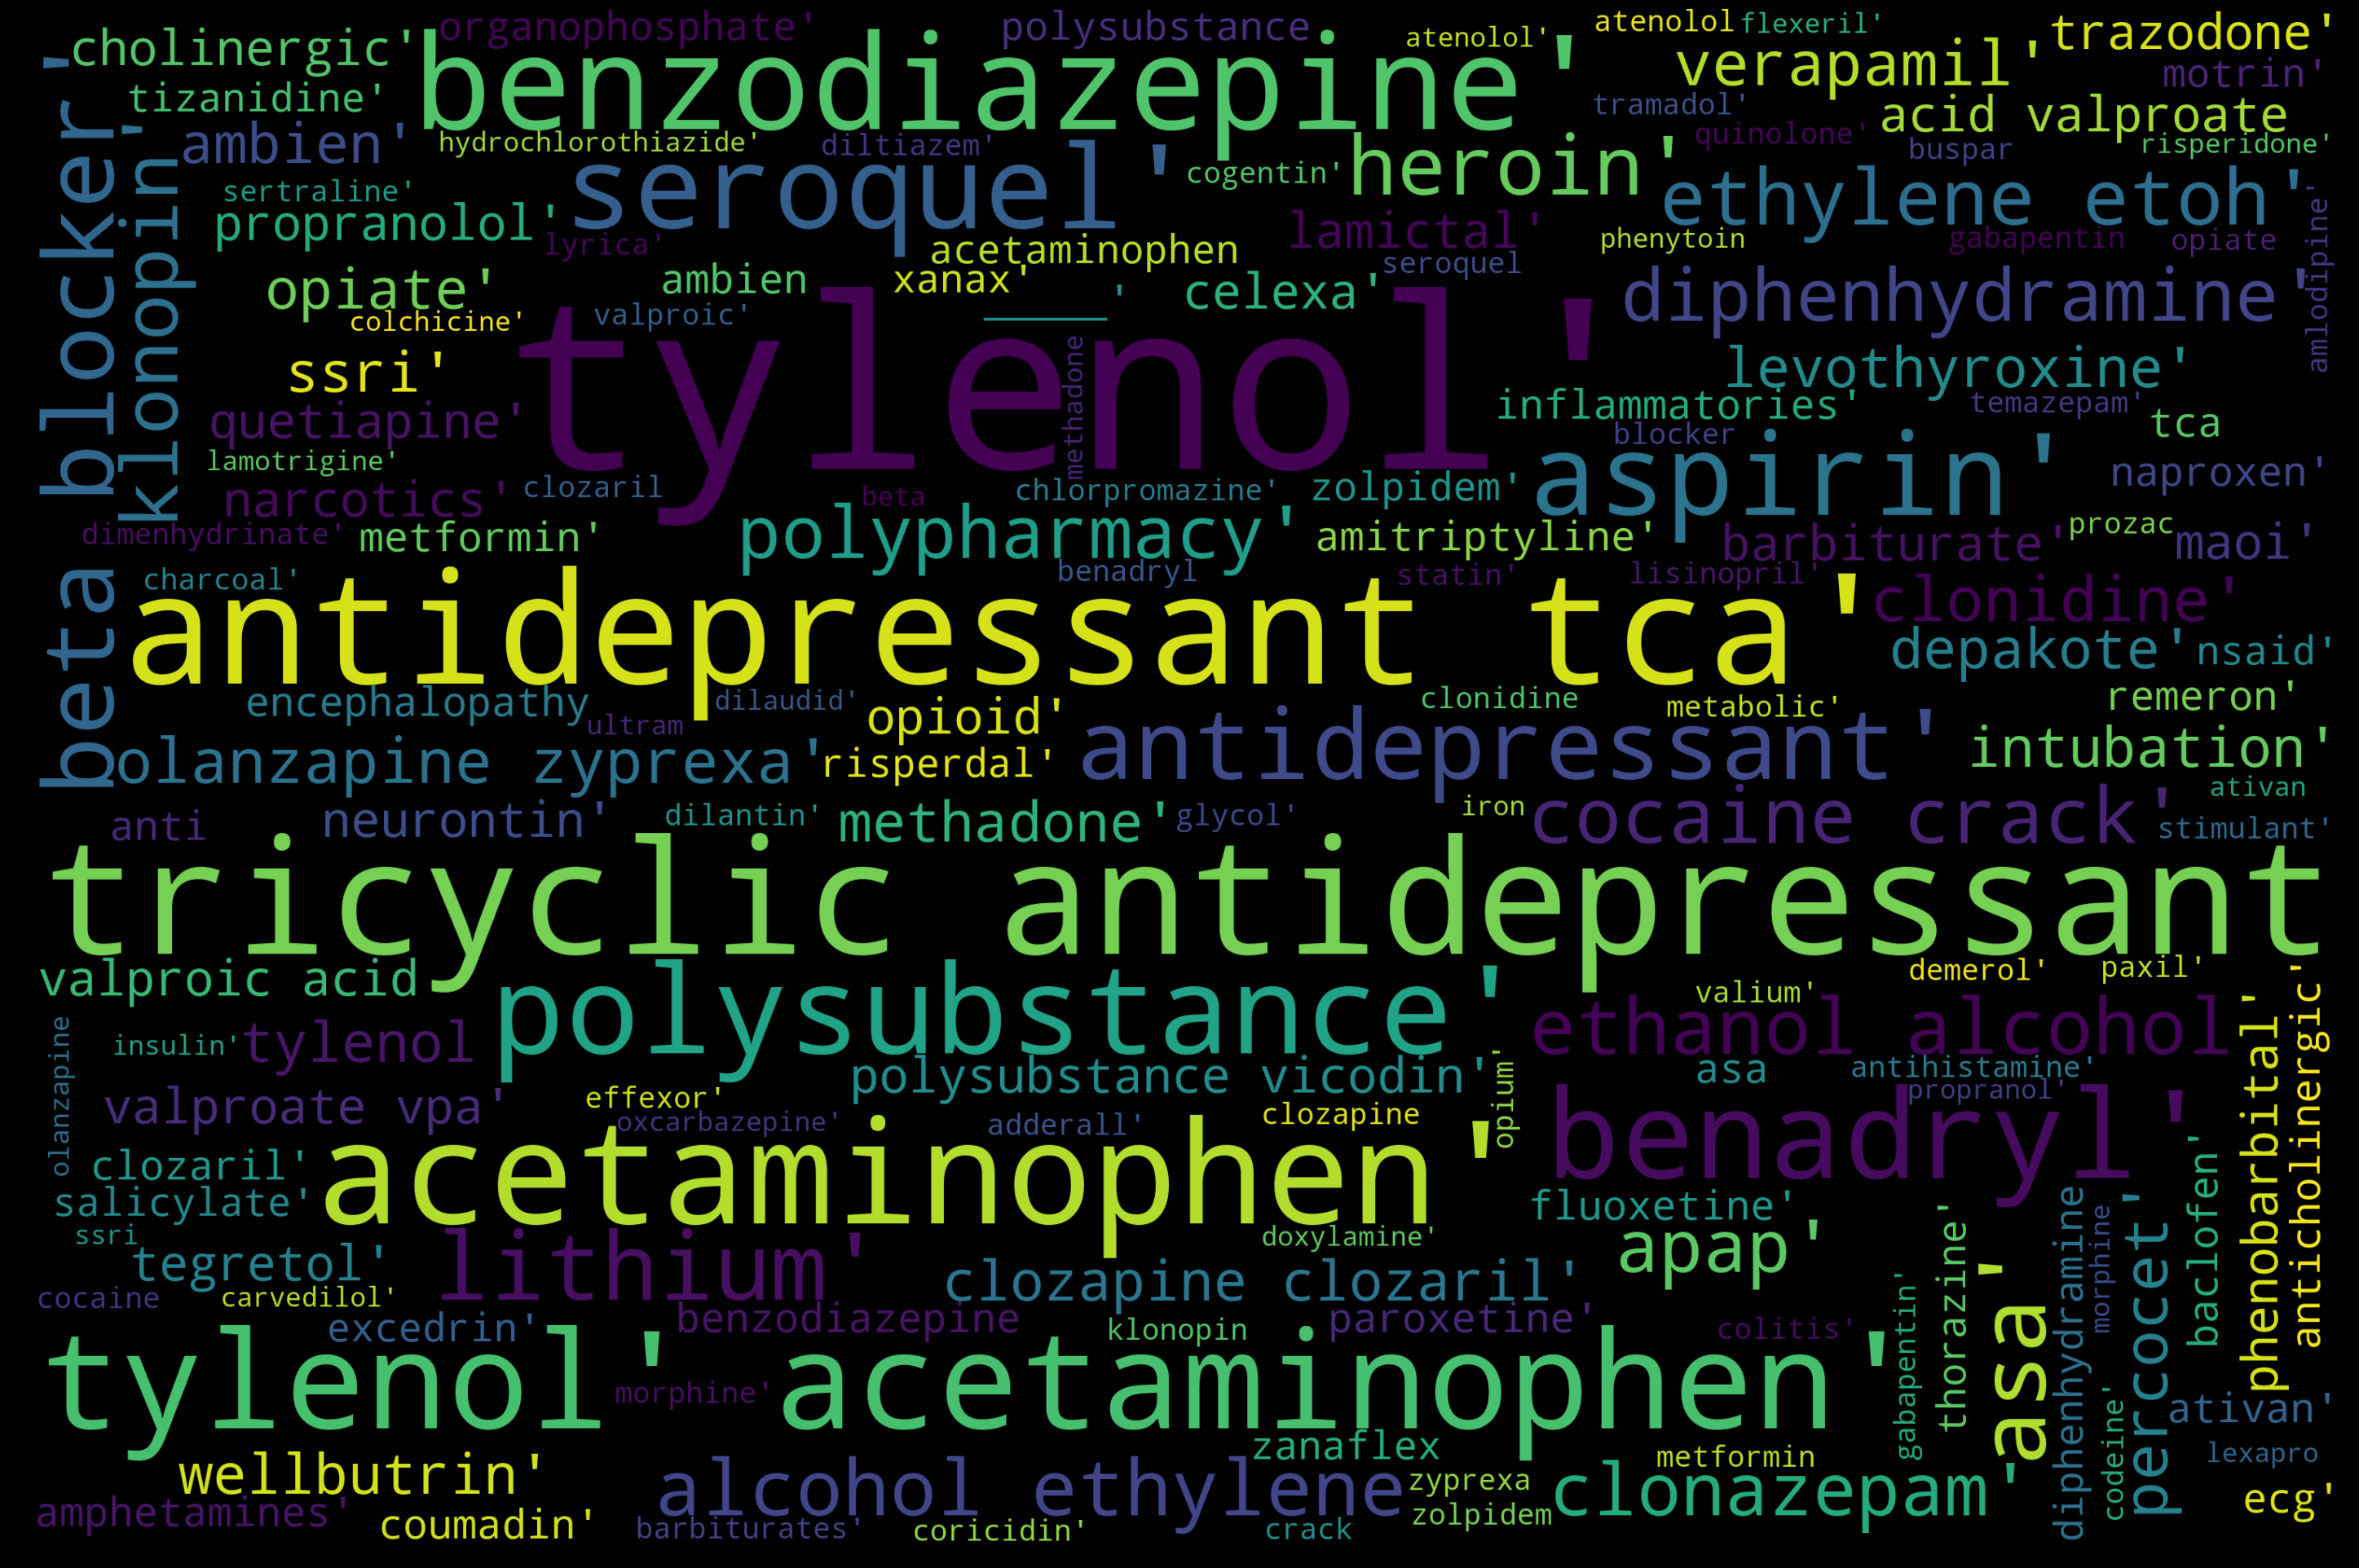

In [44]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The plot shows that the most frequently used substances are Tylenol, Tricyclic antidepressant, aspirin ...

The following steps counts the frequency of each substances and visualize the result.

In [45]:
poison_substances_counter = {}
for row in poison_substances_values:
    for item in row:
        if item not in poison_substances_counter.keys():
            poison_substances_counter[item] =1
        else:
            poison_substances_counter[item] += 1

In [46]:
poison_substances_num = pd.DataFrame.from_dict(poison_substances_counter, orient="index").sort_values(by=0, ascending=False)

In [47]:
poison_substances_num.columns=["Number"]

In [48]:
poison_substances_num["Percentage(%)"] = (poison_substances_num["Number"]/len(poison_substances_df.index)*100).round(2)

In [70]:
pd.set_option("display.max_rows", 1000)
poison_substances_num.head()

,Number,Percentage(%)
tylenol,103,28.69
acetaminophen,53,14.76
tricyclic antidepressant/tca,33,9.19
benzodiazepine,22,6.13
polysubstance,21,5.85


In [50]:
top_10 =poison_substances_num.iloc[0:10, :]

In [51]:
others = poison_substances_num.iloc[10:, :]

In [52]:
others.head()

,Number,Percentage(%)
asa,12,3.34
lithium,11,3.06
heroin,9,2.51
cocaine/crack,8,2.23
apap,7,1.95


In [53]:
sum(others["Number"])

289

In [54]:
round(sum(others["Percentage(%)"]), 2)

80.72

In [55]:
others_sumup = pd.DataFrame([[sum(others["Number"]), round(sum(others["Percentage(%)"]), 2)]], columns=['Number', 
                                                                                                        "Percentage(%)"])
others_sumup.index = ['other_substances']

In [56]:
others_sumup

,Number,Percentage(%)
other_substances,289,80.72


In [57]:
top_10_others = top_10.append(others_sumup)
top_10_others

,Number,Percentage(%)
tylenol,103,28.69
acetaminophen,53,14.76
tricyclic antidepressant/tca,33,9.19
benzodiazepine,22,6.13
polysubstance,21,5.85
benadryl,20,5.57
seroquel,19,5.29
aspirin,17,4.74
beta blocker,13,3.62
antidepressant,13,3.62


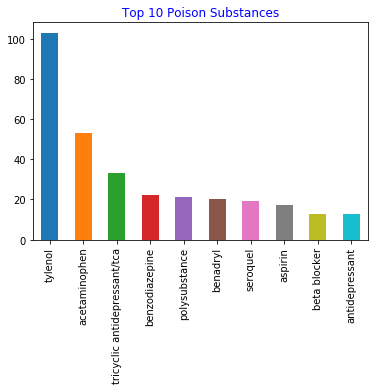

In [58]:
top_10_others.iloc[0:10, 0].plot(kind="bar")
plt.title("Top 10 Poison Substances", color="b")
plt.show()

In [59]:
list(top_10_others.index)


['tylenol',
 'acetaminophen',
 'tricyclic antidepressant/tca',
 'benzodiazepine',
 'polysubstance',
 'benadryl',
 'seroquel',
 'aspirin',
 'beta blocker',
 'antidepressant',
 'other_substances']

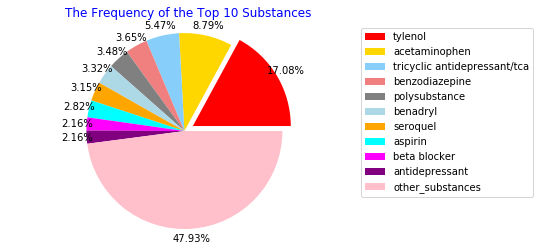

In [60]:
top_10_others.iloc[:, 0].plot(kind="pie", colors = ['red', 'gold', 'lightskyblue', 'lightcoral', "grey", 
                                                    "lightblue", "orange", "cyan", "magenta", "purple", "pink"],
                             explode=(0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
                             autopct='%1.2f%%', pctdistance=1.1, labels=None,
                            )
labels = list(top_10_others.index)
plt.axis("equal")
plt.axis('off')
plt.legend(labels, bbox_to_anchor=(1, 1))
plt.title("The Frequency of the Top 10 Substances", color = "b")
plt.show()

#  Fentanyl Discovery

The leading cause of drug overdoses in America is no longer cocaine, meth, or even heroin or common opioid painkillers like Percocet and OxyContin. It’s synthetic opioids like fentanyl and its analogs 
__Fentanyl is an extremely potent opioid.__ ("How Fentanyl Became America’s Leading Cause of Overdose Deaths", https://reachmd.com/news/how-fentanyl-became-americas-leading-cause-of-overdose-deaths/1597283/). 

In [94]:
poison_substances_num[poison_substances_num.index =="opioid"]

,Number,Percentage(%)
opioid,3,0.84


In the overdose substances disvoered above, there are only three patient hospital stays (due to drug overdose) are found using opioid. It might because the data itself doesn't have all the overdose data. Or the method used in the project doesn't work well to get all overdoes substances. In the discovery above, fentanyl is not found. Since fentanyl has become the leading overdose cause, I will try to see what ICD codes fentanyl associate with.

In [ ]:
noteevents[noteevents["TEXT"].str.contains("fentanyl")]

In [97]:
diagnoses_ICD = pd.read_csv("DIAGNOSES_ICD.csv", header=0)
